In [1]:
import pandas as pd, numpy as np, datetime as dt
import matplotlib.finance as finplt
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
import pickle

from MyModules.features import new_datetime_alpha, new_datetime_complete

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/michael/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_Delete df once window is created? As new datetimes are added, window will be extended and subsequently have the first point removed_

In [2]:
df = pd.read_csv(r'datasets/dukascopy - EURUSD_Candlestick_4_Hour_BID_31.12.2015-30.12.2016.csv',
                 parse_dates=[0], index_col=0, date_parser=lambda d: pd.datetime.strptime(d[:13], '%d.%m.%Y %H'))
df = df[(df.Open != df.High) & (df.Open != df.Low) & (df.Open != df.Close)]
cols = ['Candle Pattern', 'Same-sized Candle Trend Rejection', 'Engulfing Pattern', 'Immediate Trend Direction', 'Rejection',
        'Near Short-term Control', 'Near Long-term Control', 'In Excess Above Short-term Value', 'In Excess Below Short-term Value',
        'In Excess Above Long-term Value', 'In Excess Below Long-term Value', 'Rejected Short-term Control', 'Rejected Long-term Control',
        'Rejected Short-term Upper Limit', 'Rejected Short-term Lower Limit', 'Rejected Long-term Upper Limit', 'Rejected Long-term Lower Limit',
        'Near Short-term SR', 'Near Long-term SR', 'Near Sloped SR', 'Rejected Short-term SR line', 'Rejected Long-term SR line',
        'Rejected Sloped SR line', 'Long-term Trend Direction', 'In Excess of Long-term Value Area, Trend-following',
        'In Excess of Long-term Value Area, Counter-trend', 'Rejected Fibo level 236', 'Rejected Fibo level 382', 'Rejected Fibo level 618',
        'Closed above previous (green)', 'Close below previous (red)']
#pd.set_option("display.max_columns", 999)

# Define the window into the df, for a specified range of time. Also take into account the longterm trend behind the window
min_w_lt, min_w, max_w = (0, 450, 550)

df_longterm = df.iloc[min_w_lt:max_w, :].copy()         # long term context
df_window = df.iloc[min_w:max_w, :].copy()              # short term window
for c in cols:
    df_window[c] = np.array(np.nan)

### Modularized functions, test

In [3]:
for d in range(0, 100):
    if d == 99:
        df_longterm, df_window, shortterm_SR, longterm_SR, shortterm_trend, st_lower, st_upper, longterm_trend, lt_lower, lt_upper, sloped_sr_lines, sloped_sr_lines_starts \
        = new_datetime_complete(df_longterm, df_window, df.iloc[max_w+d, :], pip_closeness_tol=0.0008)
    else:
        df_longterm, df_window = new_datetime_alpha(df_longterm, df_window, df.iloc[max_w+d, :])

In [14]:
pickle.dump(df_window, open('First 100 points of df_window.p', 'wb'))

### This code no longer works :(
No longer keeping features in df_window except for the last row. Only 'Rejection' price is persistent
```
from matplotlib.patches import Rectangle
plt.rcParams['figure.figsize'] = (20, 13)
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
finplt.candlestick2_ohlc(ax, df_window.Open, df_window.High, df_window.Low, df_window.Close,
                         width=0.6, colorup='g', colordown='r', alpha=0.75)
maj_date_ticks = [i for i, d in enumerate(df_window.index) if str(d)[-8:][:2] == '00']
min_date_ticks = [d for d in range(len(df_window)) if d not in maj_date_ticks]
maj_date_labels = df_window.index.map(lambda d: str(d)[-14:][:5] + '          ')
min_date_labels = df_window.index.map(lambda d: str(d)[-8:][:2])
ax.set_xticks(maj_date_ticks)
ax.set_xticklabels(maj_date_labels[maj_date_ticks])
ax.set_xticks(min_date_ticks, minor = True)
ax.set_xticklabels(min_date_labels[min_date_ticks], minor = True, rotation=90)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), horizontalalignment='right', rotation=70)
# Plot colors for candle patterns + same-sized trend rejections
colors = {
    1: 'r', # Hammer (body near high)
    2: 'r', # Inverted hammer (body near low)
    8: 'r', # Hanging man
    9: 'r', # Shooting star
    3: 'b', # Spinning top
    4: 'y', # Doji with close near high
    5: 'y', # Doji with close near low
    6: 'y', # Doji with close near middle
    7: 'k'} # Marubozu
for d in range(len(df_window)):
    if df_window.iloc[d, 6] == 1:
        ax.add_patch(Rectangle((d-0.4, 0), .8, 10, facecolor='c', alpha=0.5))
    elif df_window.iloc[d, 5] != 0:
        ax.add_patch(Rectangle((d-0.4, 0), .8, 10, facecolor=colors[df_window.iloc[d, 5]], alpha=0.25))
    if df_window.iloc[d, 7] == 1:
        ax.add_patch(Rectangle((d-0.4, 0), .8, 10, facecolor='orange', alpha=0.5))
plt.show()
```
![plot that used to live in this cell](Ref/standard plot 1.png)

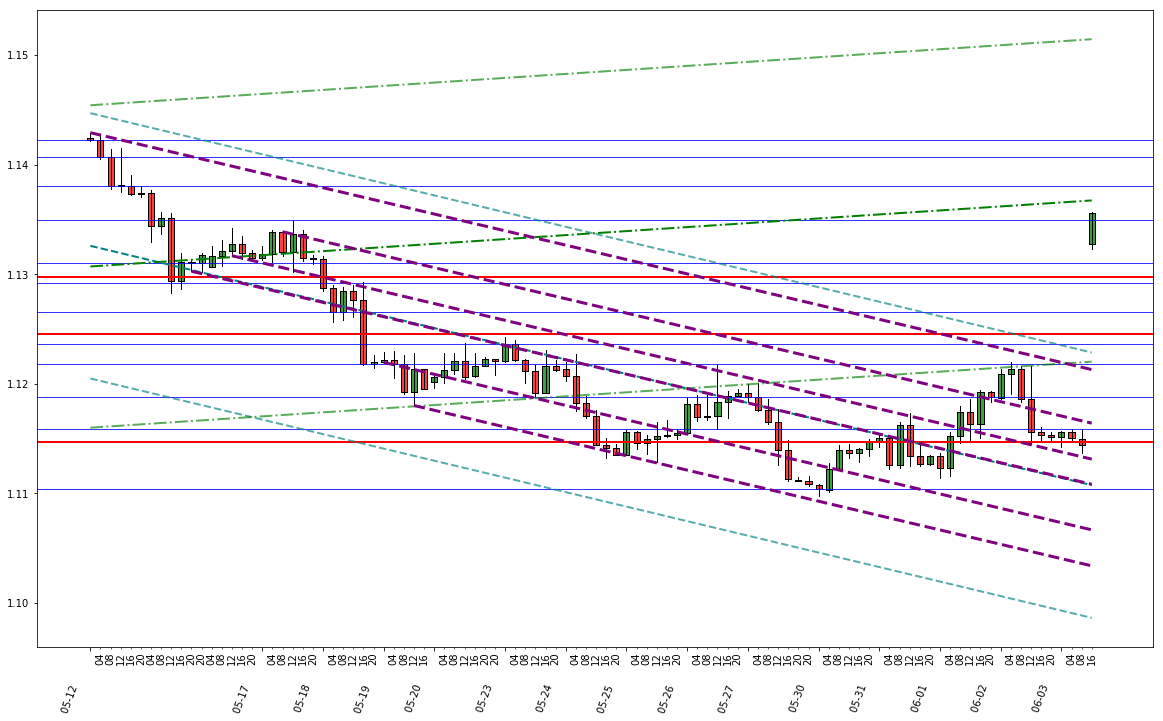

In [4]:
plt.rcParams['figure.figsize'] = (20, 13)
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
finplt.candlestick2_ohlc(ax, df_window.Open, df_window.High, df_window.Low, df_window.Close,
                         width=0.6, colorup='g', colordown='r', alpha=0.75)
maj_date_ticks = [i for i, d in enumerate(df_window.index) if str(d)[-8:][:2] == '00']
min_date_ticks = [d for d in range(len(df_window)) if d not in maj_date_ticks]
maj_date_labels = df_window.index.map(lambda d: str(d)[-14:][:5] + '          ')
min_date_labels = df_window.index.map(lambda d: str(d)[-8:][:2])
ax.set_xticks(maj_date_ticks)
ax.set_xticklabels(maj_date_labels[maj_date_ticks])
ax.set_xticks(min_date_ticks, minor = True)
ax.set_xticklabels(min_date_labels[min_date_ticks], minor = True, rotation=90)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), horizontalalignment='right', rotation=70)

# Plot the SR lines
for line in (lt for lt in longterm_SR if lt >= min(df_window.Low) and lt <= max(df_window.High)):
    plt.axhline(y=line, color='r', linewidth=2)
for line in shortterm_SR:
    plt.axhline(y=line, color='b', linewidth=0.8)
# Plot the trend lines
plt.plot(shortterm_trend.values, '--', color='teal', linewidth=2)
plt.plot(st_lower.values, '--', color='teal', linewidth=2, alpha=0.65)
plt.plot(st_upper.values, '--', color='teal', linewidth=2, alpha=0.65)
plt.plot(longterm_trend.reindex(df_window.index, axis=0).values, '-.', color='g', linewidth=2)
plt.plot(lt_lower.reindex(df_window.index, axis=0).values, '-.', color='g', linewidth=2, alpha=0.65)
plt.plot(lt_upper.reindex(df_window.index, axis=0).values, '-.', color='g', linewidth=2, alpha=0.65)
# Plot S+R lines with same slope as trend's control, determined by trend rejection candles
for i in range(len(sloped_sr_lines)):
    if sloped_sr_lines[i] != []:
        plt.plot(np.add(df_window.index.get_loc(sloped_sr_lines_starts[i]), range(len(sloped_sr_lines[i]))), sloped_sr_lines[i],
                 '--', color='purple', linewidth=3)
plt.show()